# Prophet(Facebook) and DeepAR (AWS) Comparison
By: Jhonnatan Torres

The goal of this notebook is to compare the *expected values* forecasted by these two models and compare them against the actuals in order to calculate the performance metrics and define which model performs better using this time series dataset (Covid19 Confirmed Cases for Colombia)
___ 

Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(1234)

In [3]:
plt.style.use('ggplot')

Reading the time series

In [4]:
ts = pd.read_csv('https://raw.githubusercontent.com/JOTOR/Datasets/main/Colombia_CovidV2.csv', parse_dates=True)

In [5]:
ts.head()

,item_id,timestamp,target_value
0,1,2020-03-06,1
1,1,2020-03-10,2
2,1,2020-03-11,6
3,1,2020-03-13,4
4,1,2020-03-14,9


This is the data format required by AWS Forecast, in order to use this time series with Prophet some changes are required, the first column should be removed and the names of the remaining columns should be changed

In [6]:
ts.drop(columns='item_id', inplace=True)
ts.rename(columns={'timestamp':'ds','target_value':'y'},inplace=True)

In [7]:
ts.head()

,ds,y
0,2020-03-06,1
1,2020-03-10,2
2,2020-03-11,6
3,2020-03-13,4
4,2020-03-14,9


In [8]:
ts.tail()

,ds,y
444,2021-05-28,23374
445,2021-05-29,20494
446,2021-05-30,20218
447,2021-05-31,23177
448,2021-06-01,25966


Text(0.5, 1.0, 'Time Series Plot')

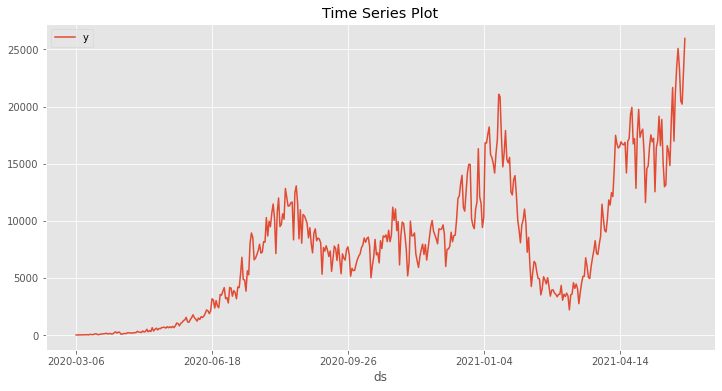

In [9]:
ts.set_index('ds').plot(figsize=(12,6))
plt.title('Time Series Plot')

## Prophet Model

In [10]:
!pip install prophet -q

In [11]:
from prophet import Prophet

In [12]:
m = Prophet(daily_seasonality=False, weekly_seasonality=True,
            yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=0.05).\
            add_country_holidays(country_name='CO')



*   Model with weekly and yearly seasonality
*   Holidays for Colombia were included, this is a time series specific for this country



In [13]:
m.fit(ts)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [14]:
future = m.make_future_dataframe(periods=30, freq='D')

In [15]:
future.tail(5)

,ds
474,2021-06-27
475,2021-06-28
476,2021-06-29
477,2021-06-30
478,2021-07-01


In [16]:
forecast = m.predict(future)

In [17]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascensión del señor [Ascension of Jesus](Observed),Ascensión del señor [Ascension of Jesus](Observed)_lower,Ascensión del señor [Ascension of Jesus](Observed)_upper,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day]_lower,Año Nuevo [New Year's Day]_upper,Batalla de Boyacá [Battle of Boyacá],Batalla de Boyacá [Battle of Boyacá]_lower,Batalla de Boyacá [Battle of Boyacá]_upper,Corpus Christi [Corpus Christi](Observed),Corpus Christi [Corpus Christi](Observed)_lower,Corpus Christi [Corpus Christi](Observed)_upper,Descubrimiento de América [Discovery of America],Descubrimiento de América [Discovery of America]_lower,Descubrimiento de América [Discovery of America]_upper,Descubrimiento de América [Discovery of America](Observed),Descubrimiento de América [Discovery of America](Observed)_lower,Descubrimiento de América [Discovery of America](Observed)_upper,Dia de Todos los Santos [All Saint's Day],Dia de Todos los Santos [All Saint's Day]_lower,Dia de Todos los Santos [All Saint's Day]_upper,Dia de Todos los Santos [All Saint's Day](Observed),Dia de Todos los Santos [All Saint's Day](Observed)_lower,Dia de Todos los Santos [All Saint's Day](Observed)_upper,Día de San José [Saint Joseph's Day](Observed),Día de San José [Saint Joseph's Day](Observed)_lower,Día de San José [Saint Joseph's Day](Observed)_upper,Día de la Independencia [Independence Day],Día de la Independencia [Independence Day]_lower,Día de la Independencia [Independence Day]_upper,Día de los Reyes Magos [Epiphany],Día de los Reyes Magos [Epiphany]_lower,Día de los Reyes Magos [Epiphany]_upper,Día de los Reyes Magos [Epiphany](Observed),...,Jueves Santo [Maundy Thursday],Jueves Santo [Maundy Thursday]_lower,Jueves Santo [Maundy Thursday]_upper,La Asunción [Assumption of Mary](Observed),La Asunción [Assumption of Mary](Observed)_lower,La Asunción [Assumption of Mary](Observed)_upper,La Inmaculada Concepción [Immaculate Conception],La Inmaculada Concepción [Immaculate Conception]_lower,La Inmaculada Concepción [Immaculate Conception]_upper,Navidad [Christmas],Navidad [Christmas]_lower,Navidad [Christmas]_upper,Sagrado Corazón [Sacred Heart](Observed),Sagrado Corazón [Sacred Heart](Observed)_lower,Sagrado Corazón [Sacred Heart](Observed)_upper,San Pedro y San Pablo [Saint Peter and Saint Paul],San Pedro y San Pablo [Saint Peter and Saint Paul]_lower,San Pedro y San Pablo [Saint Peter and Saint Paul]_upper,San Pedro y San Pablo [Saint Peter and Saint Paul](Observed),San Pedro y San Pablo [Saint Peter and Saint Paul](Observed)_lower,San Pedro y San Pablo [Saint Peter and Saint Paul](Observed)_upper,Viernes Santo [Good Friday],Viernes Santo [Good Friday]_lower,Viernes Santo [Good Friday]_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
474,2021-06-27,22557.573107,25509.395374,28438.923747,22535.353193,22580.181406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195146,0.195146,0.195146,-0.020595,-0.020595,-0.020595,0.215740,0.215740,0.215740,0.0,0.0,0.0,26959.582368
475,2021-06-28,22612.320339,23844.904208,26591.969172,22588.550547,22636.486368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113110,0.113110,0.113110,-0.111465,-0.111465,-0.111465,0.224575,0.224575,0.224575,0.0,0.0,0.0,25169.998708
476,2021-06-29,22667.067571,26237.302484,29011.104771,22641.790013,22692.471144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Text(0.5, 1.0, 'Forecast of the Time Series in the next 30 days')

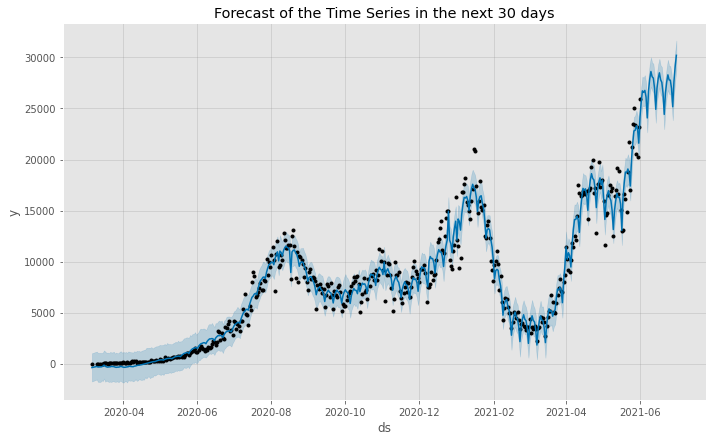

In [18]:
m.plot(forecast);
plt.title("Forecast of the Time Series in the next 30 days")

Components of the time series:


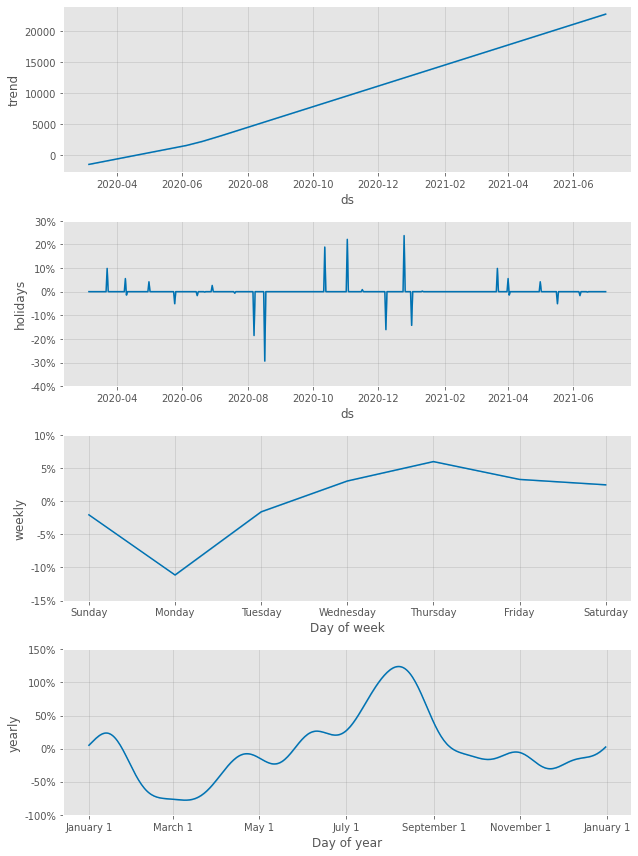

In [19]:
m.plot_components(forecast);
print("Components of the time series:")

In [20]:
detail = forecast[forecast['ds']>'2021-06-01'][['ds','yhat_lower','yhat','yhat_upper']]

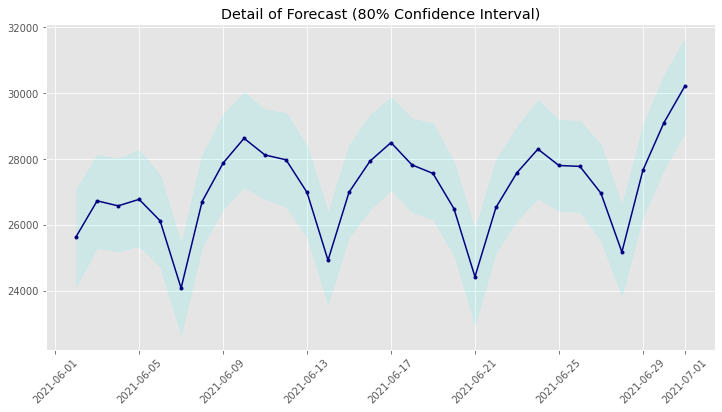

In [21]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Detail of Forecast (80% Confidence Interval)")
plt.plot(detail['ds'], detail['yhat'], marker='.', c='navy')
plt.fill_between(detail['ds'],detail['yhat_lower'], detail['yhat_upper'], alpha=0.1, color='cyan')

### Getting the actuals

In [34]:
act = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [35]:
act.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224,80841,82326,84050,85892,87716,88740,89861,91458,93272,93288,96531,98734,98734,98734,103902,105749,107957,109532,111592,111592,111592,115751,117158,118659,120216,120216,120216,120216
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379,132384,132397,132415,132426,132437,132449,132459,132461,132469,132476,132481,132484,132488,132490,132490,132496,132497,132499,132506,132509,132512,132513,132514,132521,132523,132526,132534,132535
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958,131283,131647,132034,132355,132727,133070,133388,133742,134115,134458,134840,135219,135586,135821,136294,136679,137049,137403,137772,138113,138465,138840,139229,139626,140075,140550,141007,141471
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758,13777,13781,13791,13805,13813,13813,13813,13826,13828,13836,13839,13842,13842,13842,13864,13864,13873,13877,13882,13882,13882,13882,13900,13911,13918,13918,13918,13918
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772,35854,36004,36115,36325,36455,36600,36705,36790,36921,37094,37289,37467,37604,37678,37748,37874,38002,38091,38371,38528,38556,38613,38682,38849,38965,39089,39172,39230


In [36]:
act = act.loc[act['Country/Region']=='Colombia'].drop(columns=['Province/State', 'Lat', 'Long'])

In [37]:
act = pd.melt(act, id_vars='Country/Region', var_name='ds', value_name='y').drop(columns='Country/Region')

In [38]:
act['ds'] = pd.to_datetime(act['ds'])

In [39]:
act.tail()

,ds,y
525,2021-06-30,4240982
526,2021-07-01,4269297
527,2021-07-02,4297302
528,2021-07-03,4324230
529,2021-07-04,4350495


These are the cumulative numbers and the time series used in the model was the difference between the dates ( Date B - Date A )

In [40]:
#Calculating the difference
act = act.set_index('ds').diff().reset_index()

Text(0.5, 1.0, 'Time Series of Actual Values')

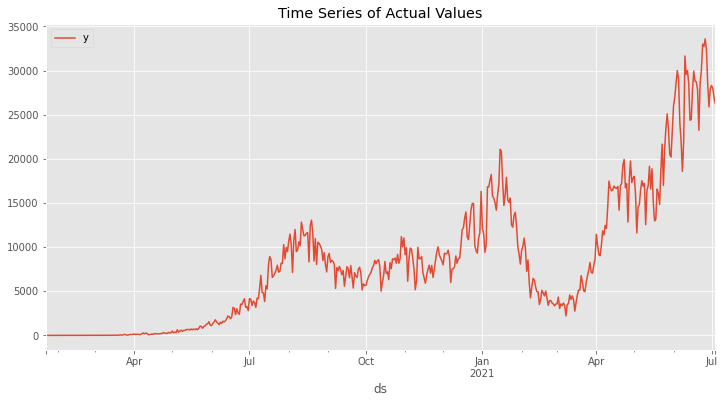

In [41]:
act.set_index('ds').plot(figsize=(12,6))
plt.title("Time Series of Actual Values")

In [42]:
act = act[(act['ds']>'2021-06-01') & (act['ds']<'2021-07-02')]

Text(0.5, 1.0, 'Detail of Actual Values')

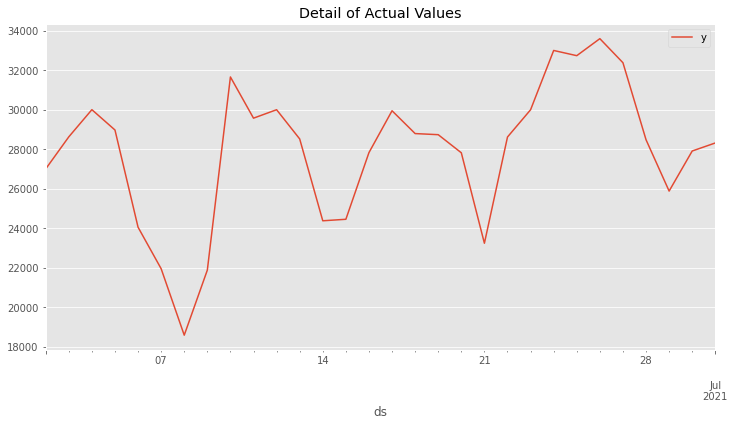

In [43]:
act.set_index('ds').plot(figsize=(12,6))
plt.title("Detail of Actual Values")

After all these transformations, these are the actual numbers for the days between June 2nd and July 1st

In [44]:
act.head()

,ds,y
497,2021-06-02,27000.0
498,2021-06-03,28624.0
499,2021-06-04,30000.0
500,2021-06-05,28971.0
501,2021-06-06,24050.0


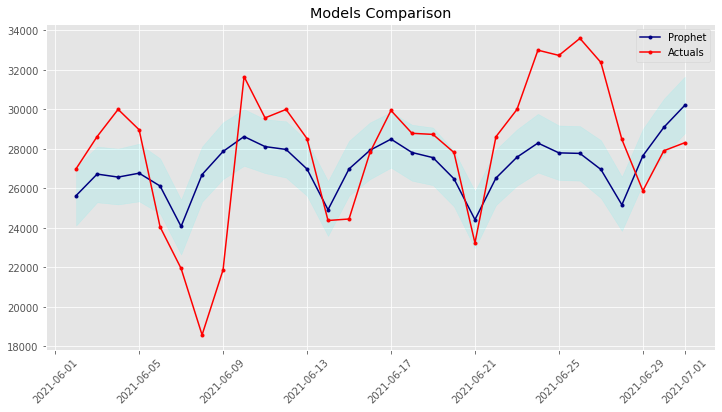

In [45]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Models Comparison")
plt.plot(detail['ds'], detail['yhat'], marker='.', c='navy', label='Prophet')
plt.fill_between(detail['ds'],detail['yhat_lower'], detail['yhat_upper'], alpha=0.1, color='cyan')
plt.plot(act['ds'], act['y'], c='red', label='Actuals', marker='.')
plt.legend()

In my humble opinion, these time series analysis should be understood as the *expected values* based on some past observations rather than actual predictions or forecasts, in this specific case, mostly of the expected values are below the actuals, suggesting *a situation worst than expected*

### Performance Metrics

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:
prophet_mae = mean_absolute_error(act['y'], detail['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(act['y'], detail['yhat']))

In [48]:
print("Prophet RMSE: {:.4f}".format(prophet_rmse))
print("Prophet MAE: {:.4f}".format(prophet_mae))

Prophet RMSE: 3181.5410
Prophet MAE: 2602.5321


## DeepAR

Like one month ago, I used the time series data to train a DeepAR model in Amazon Forecast, according to the billing detail the model took around 3.5 Hours to be trained

In [49]:
aws = pd.read_csv('https://raw.githubusercontent.com/JOTOR/Datasets/main/aws_forecast_output_covidcolombia.csv')

In [50]:
aws.head()

,item_id,date,mean,p90
0,1,2021-06-02T00:00:00Z,24462.335938,26806.851562
1,1,2021-06-03T00:00:00Z,22834.626953,24922.527344
2,1,2021-06-04T00:00:00Z,21760.427734,23344.367188
3,1,2021-06-05T00:00:00Z,23789.902344,25332.390625
4,1,2021-06-06T00:00:00Z,24668.457031,26227.664062


AWS provides the mean of the forecast and a 90% upper confidence interval

In [51]:
aws['date'] = pd.to_datetime(aws['date'])

In [52]:
aws['date'] = aws['date'].dt.date

In [53]:
aws.drop(columns='item_id', inplace=True)

In [54]:
aws.head()

,date,mean,p90
0,2021-06-02,24462.335938,26806.851562
1,2021-06-03,22834.626953,24922.527344
2,2021-06-04,21760.427734,23344.367188
3,2021-06-05,23789.902344,25332.390625
4,2021-06-06,24668.457031,26227.664062


### Model Comparison

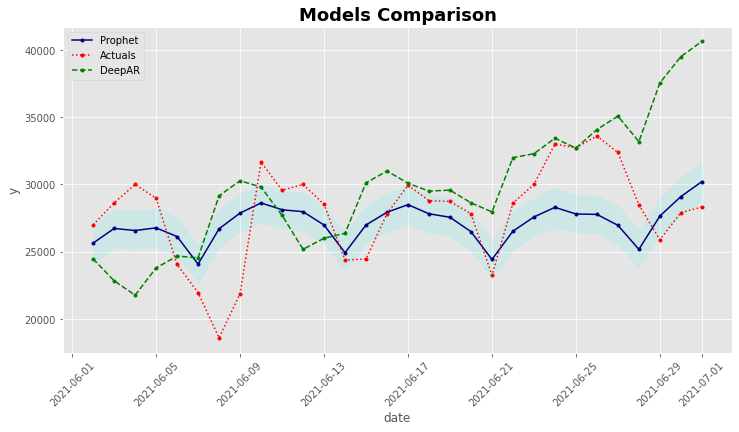

In [55]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Models Comparison", fontweight='bold', fontsize=18)
plt.plot(detail['ds'], detail['yhat'], marker='.', c='navy', label='Prophet')
plt.fill_between(detail['ds'],detail['yhat_lower'], detail['yhat_upper'], alpha=0.1, color='cyan')

plt.plot(act['ds'], act['y'], c='red', label='Actuals', marker='.', linestyle='dotted')

plt.plot(aws['date'], aws['mean'], c='green', label='DeepAR', marker='.', linestyle='dashed')
plt.xlabel('date')
plt.ylabel('y')
plt.legend()

In [56]:
aws_mae = mean_absolute_error(act['y'], aws['mean'])
aws_rmse = np.sqrt(mean_squared_error(act['y'], aws['mean']))

### Performance Metrics

In [57]:
print("Prophet RMSE: {:.4f}".format(prophet_rmse))
print("DeepAR RMSE: {:.4f}".format(aws_rmse))
print('\n')
print("Prophet MAE: {:.4f}".format(prophet_mae))
print("DeepAR MAE: {:.4f}".format(aws_mae))

Prophet RMSE: 3181.5410
DeepAR RMSE: 5477.5270


Prophet MAE: 2602.5321
DeepAR MAE: 4089.6940


## Conclusion

> At least for this particular dataset, Prophet model had a better "performance metrics" compared to the actual values.
It seems like the DeepAR model was influenced by the trend and for that reason provided higher expected values.

>**DeepAR:** The actual values are below the expected values by this model, suggesting a *situation better than the expected* (at least for the second half of the month)

>**Prophet:** Mostly of the actual values are above the *expected values* provided by this model, suggesting a *situation worst than expected*

## References



*   https://github.com/CSSEGISandData/COVID-19
*   https://facebook.github.io/prophet/docs/quick_start.html#python-api

